## Stable Diffusion fine tune with Lora in DreamBooth method
* Style training example —— Caption method
* Tested with ml.g4dn.xlarge SageMaker notebook.
* Scripts and codes use [kohya-ss/sd-scripts](https://github.com/kohya-ss/sd-scripts).
* Lora training is basing on the method of DreamBooth+Caption(without using class_images to aviod over-fitting). 
* Besides the way of DreamBooth+Caption, Lora can also use other methods, such as DreamBooth+Identifier+Class and classic text2image fine tuning. Detailed info you can refer to https://github.com/kohya-ss/sd-scripts/blob/main/train_README-ja.md
* If you can read Chinese and feel hard to dig into kohya-ss repo(Japanese content for now ...), you can map the content from [Akegarasu repo](https://github.com/Akegarasu/lora-scripts) to kohya-ss for better understanding


## 1. Install dependencies

In [ ]:
!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install xformers==0.0.18

In [ ]:
!git clone https://github.com/kohya-ss/sd-scripts
%cd sd-scripts/
!pip install -U -r requirements.txt
!pip install --upgrade lion-pytorch lycoris-lora

In [ ]:
# fix some warnings and bugs poping up from notebook

!pip install tensorflow==2.11.0
!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

## 2. Initialize training environment 

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

Refer "dataset-example.toml" to configure your own .toml file

In [ ]:
%%writefile dataset.toml
[general]
enable_bucket = true
shuffle_caption = true
caption_extension = '.txt'
keep_tokens = 0
color_aug = true

# DreamBooth caption based style datasets
[[datasets]]
resolution = 512
batch_size = 2

  [[datasets.subsets]]
  image_dir = './images/sample'
  num_repeats = 10

In [6]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
DATASET_CONFIG = "./dataset.toml"
TRAIN_DATA_DIR = "./images/sample"
IMAGES_OUTPTS = "./images/outputs"
!mkdir -p $TRAIN_DATA_DIR $IMAGES_OUTPTS

In [ ]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/source/* $TRAIN_DATA_DIR
!rm -rf dreambooth-stablediffusion-sagemaker-notebook

## 3. Train model

In [ ]:
!accelerate launch train_network.py \
   --pretrained_model_name_or_path=$MODEL_NAME \
   --dataset_config=$DATASET_CONFIG \
   --output_dir="./output" \
   --logging_dir="./logs" \
   --network_module="networks.lora" \
   --max_train_epochs=10 \
   --learning_rate="1e-4" \
   --unet_lr="1e-4" \
   --text_encoder_lr="1e-5" \
   --lr_scheduler="cosine_with_restarts" \
   --lr_warmup_steps=0 \
   --lr_scheduler_num_cycles=1 \
   --network_dim=64 \
   --network_alpha=32 \
   --output_name="lora_cypk" \
   --save_every_n_epochs=2 \
   --mixed_precision="fp16" \
   --gradient_checkpointing \
   --clip_skip=2 \
   --prior_loss_weight=1 \
   --max_token_length=225 \
   --save_model_as="safetensors" \
   --noise_offset=0.1 \
   --xformers --use_8bit_adam \

## 4. Mode inference testing

creating pipe from runwayml/stable-diffusion-v1-5...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

loading lora networks...
create LoRA network from weights
create LoRA for Text Encoder: 72 modules.
create LoRA for U-Net: 192 modules.
enable LoRA for text encoder
enable LoRA for U-Net
generating image...


  0%|          | 0/20 [00:00<?, ?it/s]

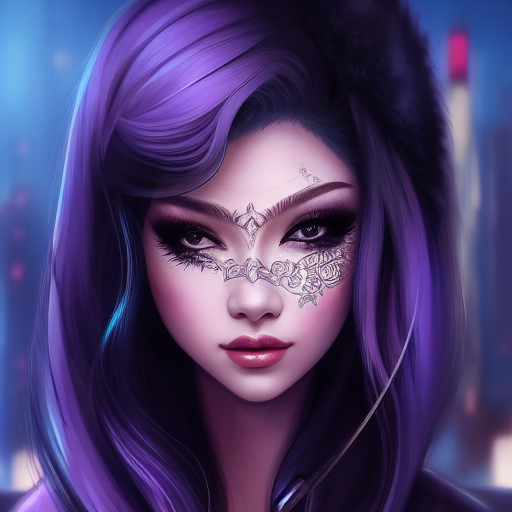

./images/outputs/5379135033180209_2023-04-20 09:08:23.png



  0%|          | 0/20 [00:00<?, ?it/s]

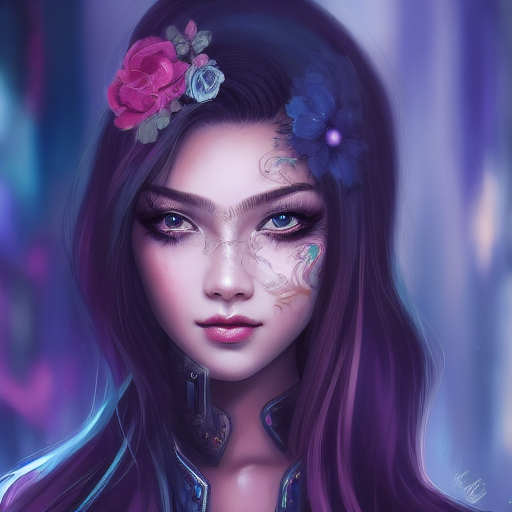

./images/outputs/3439360791019107_2023-04-20 09:08:29.png


Seeds for generating images: [5379135033180209, 3439360791019107]



In [11]:
import torch
import datetime

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
from networks.lora import LoRAModule, create_network_from_weights
from safetensors.torch import load_file

model_id_or_dir = r"runwayml/stable-diffusion-v1-5"

# create pipe
print(f"creating pipe from {model_id_or_dir}...")
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id_or_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_id_or_dir, custom_pipeline="lpw_stable_diffusion", scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
vae = pipe.vae
text_encoder = pipe.text_encoder
unet = pipe.unet

# load lora networks
print(f"loading lora networks...")

lora_path = r"./output/lora_cypk.safetensors"
sd = load_file(lora_path)   # If the file is .ckpt, use torch.load instead.
network, sd = create_network_from_weights(1.0, None, vae, text_encoder,unet, sd)
network.apply_to(text_encoder, unet)
network.load_state_dict(sd)
network.to("cuda", dtype=torch.float16)

# Uncomment below codes, if you don't want to enable NFSW
def dummy(images, **kwargs):
    return images, False
pipe.safety_checker = dummy

# prompts
prompt = "cypk style, portrait of girl, pretty detailed face, intricate eyes, frontal view, upper body, city background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), text, logo, watermark"

# exec pipe
print("generating image...")

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    with torch.autocast("cuda"):
        image = pipe(
            prompt, 
            negative_prompt=negative_prompt,
            height=512,
            width=512,
            num_images_per_prompt=1,
            num_inference_steps=20,
            guidance_scale=7, 
            generator = generator
        ).images[0]
        display(image)
        now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
        print(file_path + "\n")
        image.save(file_path)

# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")

  0%|          | 0/20 [00:00<?, ?it/s]

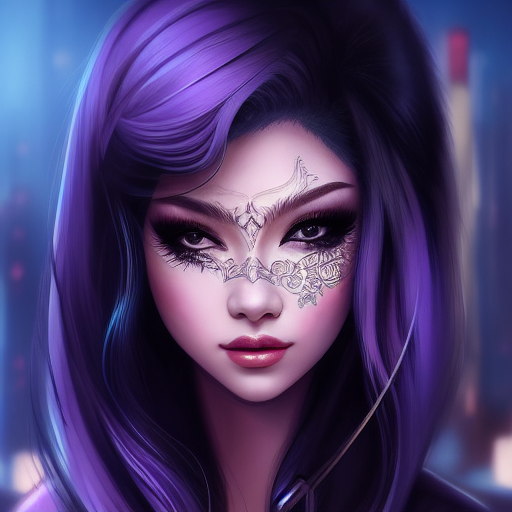

In [12]:
# Comment below codes, if you don't want to produce the same images again
seed = seeds[0] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=512,
    width=512,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7.5,
    generator = generator
).images[0]
display(image)